In [1]:
import os

os.environ["WANDB_API_KEY"] = "9de5cf75375e02a416a8db03eb6ab953dd1dd640"
os.environ["WANDB_MODE"] = "offline"

In [2]:
import wandb
from src.tools import fig2data, fig2img # for wandb

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import sys, json, gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.autograd import grad
import torch.autograd as autograd

from src.plotters import plot_low_dim_equal
from src.tools_wo_crop import unfreeze, freeze
from scipy import linalg
from sklearn import datasets, manifold
from mpl_toolkits.mplot3d import Axes3D

## Configuration 

In [3]:
SEED = 9999
torch.manual_seed(SEED)

cuda = True if torch.cuda.is_available() else False

In [4]:
BATCH_SIZE = 400
GPU_DEVICE = 0

dim = 2
K_G = 16
K_psi = 1

lam_go = 0.1

lr_G = 1e-3
lr_psi = 1e-3

DATASET1, DATASET2 = 'gauss', 'swirl'
COST = 'MeanNegBilinear'

EXP_NAME = f'{DATASET1}_{DATASET2}_{COST}_T{K_G}'

In [5]:
if cuda:
    print('Using GPU: ', GPU_DEVICE)
    torch.cuda.set_device(GPU_DEVICE)

Using GPU:  0


In [6]:
config = dict(
    BATCH_SIZE = BATCH_SIZE,
    LATENT_DIM =  dim,
    K_G = K_G,
    K_psi = K_psi,
    LAM_GO = lam_go,
    LR_G = lr_G, LR_psi = lr_psi
)

## Sampling from data distribution

In [7]:
class SyntheticDataGenerator(object):
    """superclass of all synthetic data. WARNING: doesn't raise StopIteration so it loops forever!"""

    def __iter__(self):
        return self

    def __next__(self):
        return self.get_batch()

    def get_batch(self):
        raise NotImplementedError()

    def float_tensor(self, batch):
        return torch.from_numpy(batch).type(torch.FloatTensor)

In [8]:
class StandardGaussianGenerator(SyntheticDataGenerator):
    """samples from Standard Gaussian."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float=1.,
                 eps_noise: float=1.):
        self.batch_size = batch_size
        scale = scale
        self.eps_noise = eps_noise

    def get_batch(self):
        batch = []
        for _ in range(self.batch_size):
            point = np.random.randn(2) * self.eps_noise
            batch.append(point)
        batch = np.array(batch, dtype='float32')
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch

In [9]:
class SwissRollGenerator(SyntheticDataGenerator):
    """samples from Swiss Roll."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float = .5,
                 noise: float= 0.01):
        self.batch_size = batch_size
        self.scale = scale
        self.noise = noise

    def get_batch(self):
        X, c = datasets.make_swiss_roll(self.batch_size, noise=self.noise)
        batch = X[:,[2,0]]*self.scale
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch

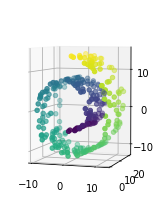

In [10]:
X, c = datasets.make_swiss_roll(300, random_state=0)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(251, projection="3d")
ax.scatter(X[:,0],X[:,1],X[:,2], c=c)
ax.view_init(4,-72)

In [11]:
X_sampler = StandardGaussianGenerator(BATCH_SIZE)
Y_sampler = SwissRollGenerator(BATCH_SIZE)


In [12]:
X_samples = next(X_sampler)
Y_samples = next(Y_sampler)

X_samples.shape, Y_samples.shape

(torch.Size([400, 2]), torch.Size([400, 2]))

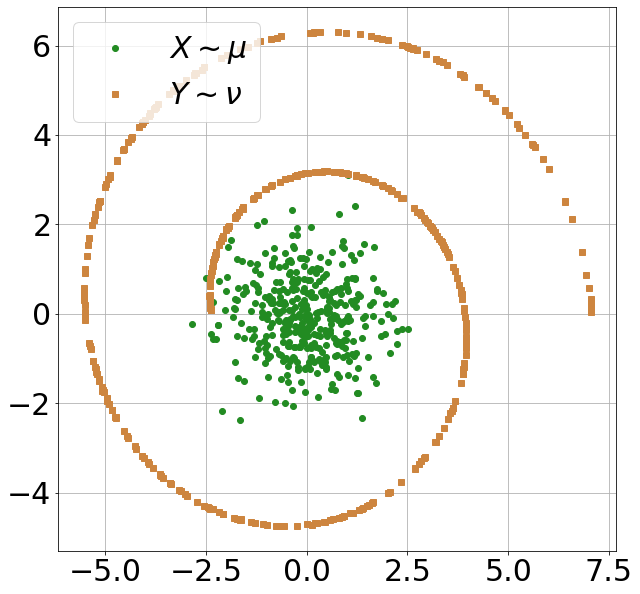

In [13]:
plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(10,10))
plt.plot(X_samples[:,0].numpy(), X_samples[:,1].numpy(),'og',label=r'$X \sim \mu$', color='forestgreen')
plt.plot(Y_samples[:,0].numpy(), Y_samples[:,1].numpy(),'s', label=r'$Y \sim \nu$', color='peru')
plt.grid()
plt.legend(loc='upper left')

## Design transport map

In [14]:
class MLP_G(nn.Module):
    def __init__(self, features = 128):
        super(MLP_G, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=dim, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=dim)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op

In [15]:
# Generator
G = nn.Sequential(
    MLP_G(features=128),
)
G = G.cuda()

In [16]:
summary(G,(dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                    [-1, 2]             258
             MLP_G-5                    [-1, 2]               0
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## Design potential functional

In [17]:
class MLP_D(nn.Module):
    def __init__(self, features = 128):
        super(MLP_D, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=dim, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op

In [18]:
# Potential
psi = nn.Sequential(
    MLP_D(features=128),
)

psi = psi.cuda()

In [19]:
summary(psi, (dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                    [-1, 1]             129
             MLP_D-5                    [-1, 1]               0
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## Design embedding function

In [20]:
Q = lambda X: X.detach() # Embedding Q

## Training Loss

In [21]:
def GradientOptimality(psi, G, Q, x):
    """ Gradient Optimality cost for potential"""
    G_x = G(x).cuda()
    G_x.requires_grad_(True)
    psi_G_x = psi(G_x)

    gradients = autograd.grad(
        outputs=psi_G_x, inputs=G_x,
        grad_outputs=torch.ones(psi_G_x.size()).to(G_x),
        create_graph=True, retain_graph=True
    )[0]
    return (gradients.mean(dim=0) - Q(x).mean(dim=0)).norm('fro')

def Loss(psi, G, Q, X, Y):
    G_X = G(X)
    loss = (Q(X) * G_X).mean(dim=1).mean() - psi(G_X).mean() + psi(Y).mean()
    return loss

## Testing plot functions for training visualization

In [22]:
n = BATCH_SIZE

X_fixed = next(X_sampler)
Y_fixed = next(Y_sampler)

X_fixed = X_fixed[:n].cuda()
Y_fixed = Y_fixed[:n].cuda()


G_opt = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.99))
psi_opt = torch.optim.Adam(psi.parameters(), lr=lr_psi, betas=(0.5, 0.99))

FID_history = []

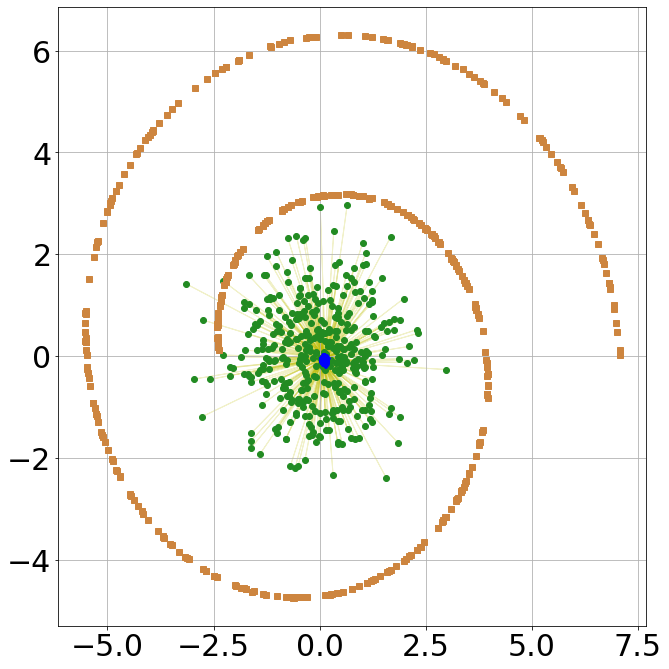

In [23]:
fig, axes = plot_low_dim_equal(G, Q, X_fixed, Y_fixed)
plt.close(fig)

In [24]:
G(X_fixed).type(), Y_fixed.type()

('torch.cuda.FloatTensor', 'torch.cuda.FloatTensor')

In [25]:
go_loss = GradientOptimality(psi, G, Q, X_fixed)
go_loss

tensor(0.0754, device='cuda:0', grad_fn=<NormBackward0>)

In [26]:
loss = Loss(psi,G, Q, X_fixed, Y_fixed)
loss

tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
wandb.init(name=EXP_NAME, project='Toy Generative Modeling', config=config, entity='liturout')
pass

wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


## Main training of latent space mass transport

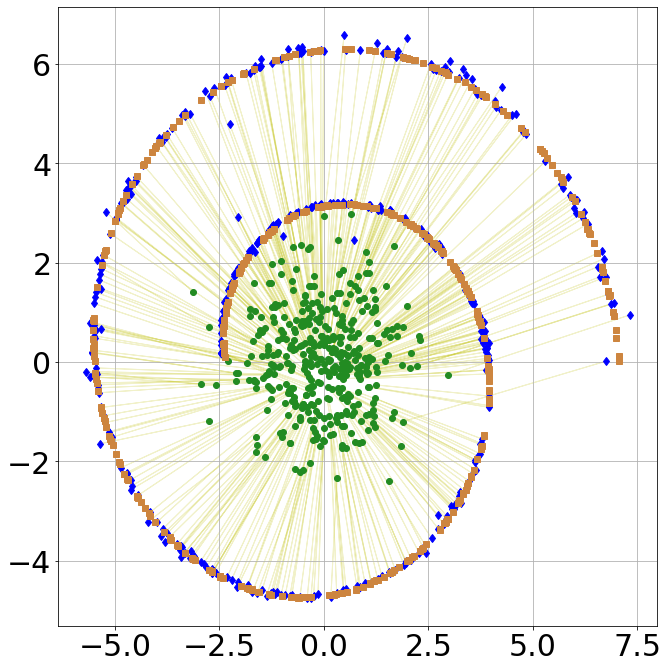

In [28]:
for it in range(10000+1):    
    ##########################################################
    ## Outer minimization loop
    ##########################################################   
    freeze(G); unfreeze(psi)
    for k_psi in range(K_psi):
        X = next(X_sampler).cuda()
        Y = next(Y_sampler).cuda()
        
        go_loss = GradientOptimality(psi, G, Q, X)
        psi_loss = Loss(psi, G, Q, X, Y) + lam_go * go_loss
        psi_opt.zero_grad(); psi_loss.backward(); psi_opt.step()
    
    # log params
    wandb.log({f'Loss/Psi_loss' : np.round(psi_loss.item(),5)}, it)
    wandb.log({f'Loss/GO_loss' : np.round(go_loss.item(),5)}, it)
    del go_loss; psi_loss; gc.collect(); torch.cuda.empty_cache()

    ##########################################################
    ## Inner maximization loop
    ##########################################################
    freeze(psi); unfreeze(G)
    for k_G in range(K_G):
        X = next(X_sampler).cuda()
        Y = next(Y_sampler).cuda()
                
        G_loss = -Loss(psi, G, Q, X, Y)
        G_opt.zero_grad(); G_loss.backward(); G_opt.step()
    # log params
    wandb.log({f'Loss/G_loss' : np.round(G_loss.item(),5)}, it)
    del G_loss; gc.collect(); torch.cuda.empty_cache()   
        
    if it % 50 == 0:
        clear_output(wait=True)
        fig, axes = plot_low_dim_equal(G, Q, X_fixed, Y_fixed)
        wandb.log({'Results/Fixed Mapping' : [wandb.Image(fig2img(fig))]}, it)        
        plt.close(fig)    
                        
    if it % 1000 == 0:
        gc.collect(); torch.cuda.empty_cache()

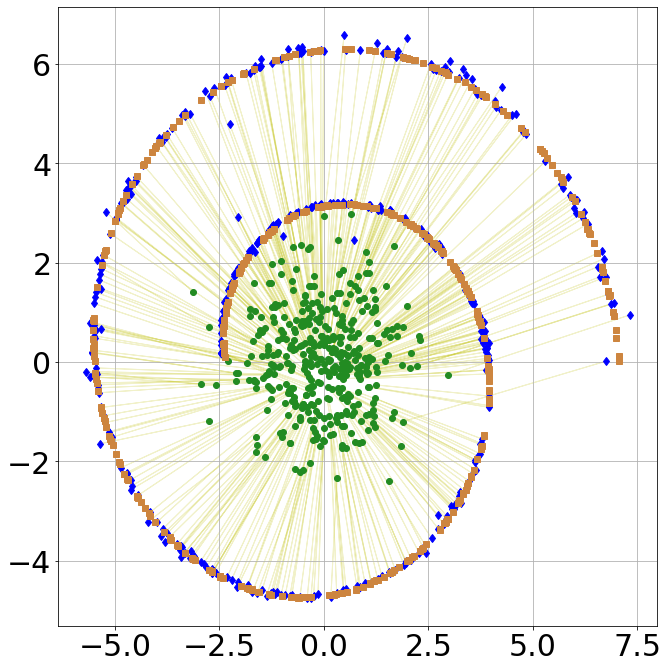

In [29]:
freeze(G), freeze(psi)
fig, axes = plot_low_dim_equal(G, Q, X_fixed, Y_fixed)
fig.savefig('./output/Toy/Swirl/otm_swirl.pdf', bbox_inches='tight')